# ResPlan Utilities — Non-DL Helpers Demo

This notebook demonstrates **non–deep-learning** utilities for the ResPlan-style floorplan dataset, using the helper module `resplan_utils.py`.

**What you'll see:**
- Loading a pickled list of plans (`ResPlan.pkl`)
- Plotting plans with clean colors
- Converting arbitrary geometries (Polygon / MultiPolygon / LineString / Point) into binary masks
- Simple geometry augmentations (rotate / vertical flip / scale)
- Room graph extraction (nodes = rooms; edges = adjacency or via door/window)
- Graph overlay on the plan
- (Optional) Batch export of figures

> Dependencies: `shapely`, `geopandas`, `matplotlib`, `networkx`, `numpy`, `opencv-python` (see the `resplan_utils.py` header).

## 1) Setup & Imports

In [10]:
# If this notebook runs in a different working directory, make sure the path
# to resplan_utils.py is visible (here we add /mnt/data).
import sys, os, pickle, random
sys.path.append('/mnt/data')

# Core scientific stack
import numpy as np
import matplotlib.pyplot as plt

# Utilities (non-DL) for ResPlan
from resplan_utils import (
    CATEGORY_COLORS,
    normalize_keys, get_plan_width,
    get_geometries, centroid,
    geometry_to_mask,
    augment_geom,
    buffer_shrink_expand, buffer_expand_shrink,
    plot_plan,
    plan_to_graph, plot_plan_and_graph
)

plt.rcParams['figure.dpi'] = 110
print('Environment ready.')

Environment ready.


## 2) Load the ResPlan dataset

In [11]:
# By default, we load from /mnt/data. Change DATA_PATH if needed.
DATA_PATH = 'ResPlan.pkl'

with open(DATA_PATH, 'rb') as f:
    plans = pickle.load(f)

print(f'Loaded {len(plans)} plans')
# Peek at keys of the first plan
example = plans[0]
print('Sample keys:', list(example.keys())[:20])

# Normalize common key typos (e.g., balacony -> balcony) in-place for safety
for p in plans:
    normalize_keys(p)

Loaded 17107 plans
Sample keys: ['balcony', 'bathroom', 'bedroom', 'door', 'garden', 'inner', 'parking', 'pool', 'stair', 'veranda', 'wall', 'window', 'front_door', 'unitType', 'id', 'kitchen', 'land', 'net_area', 'area', 'storage']


## 3) Plot a single plan

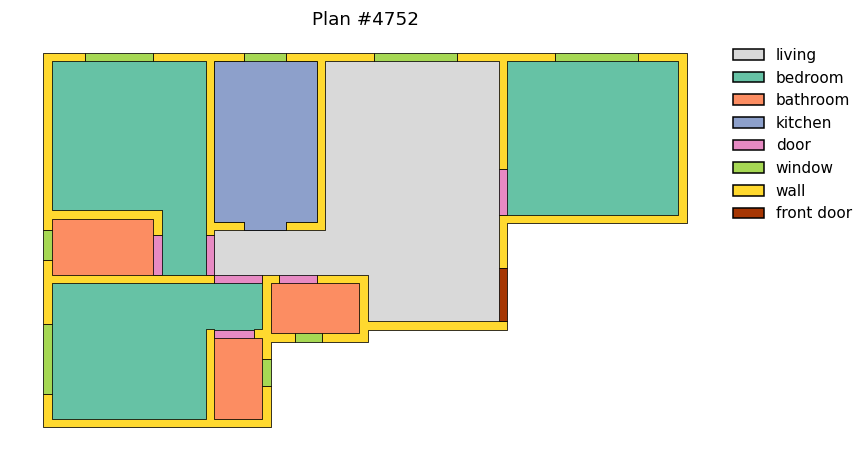

In [12]:
idx = random.randrange(len(plans))
plan = plans[idx]
ax = plot_plan(plan, title=f'Plan #{idx}')
plt.show()

## 4) Geometry → mask examples

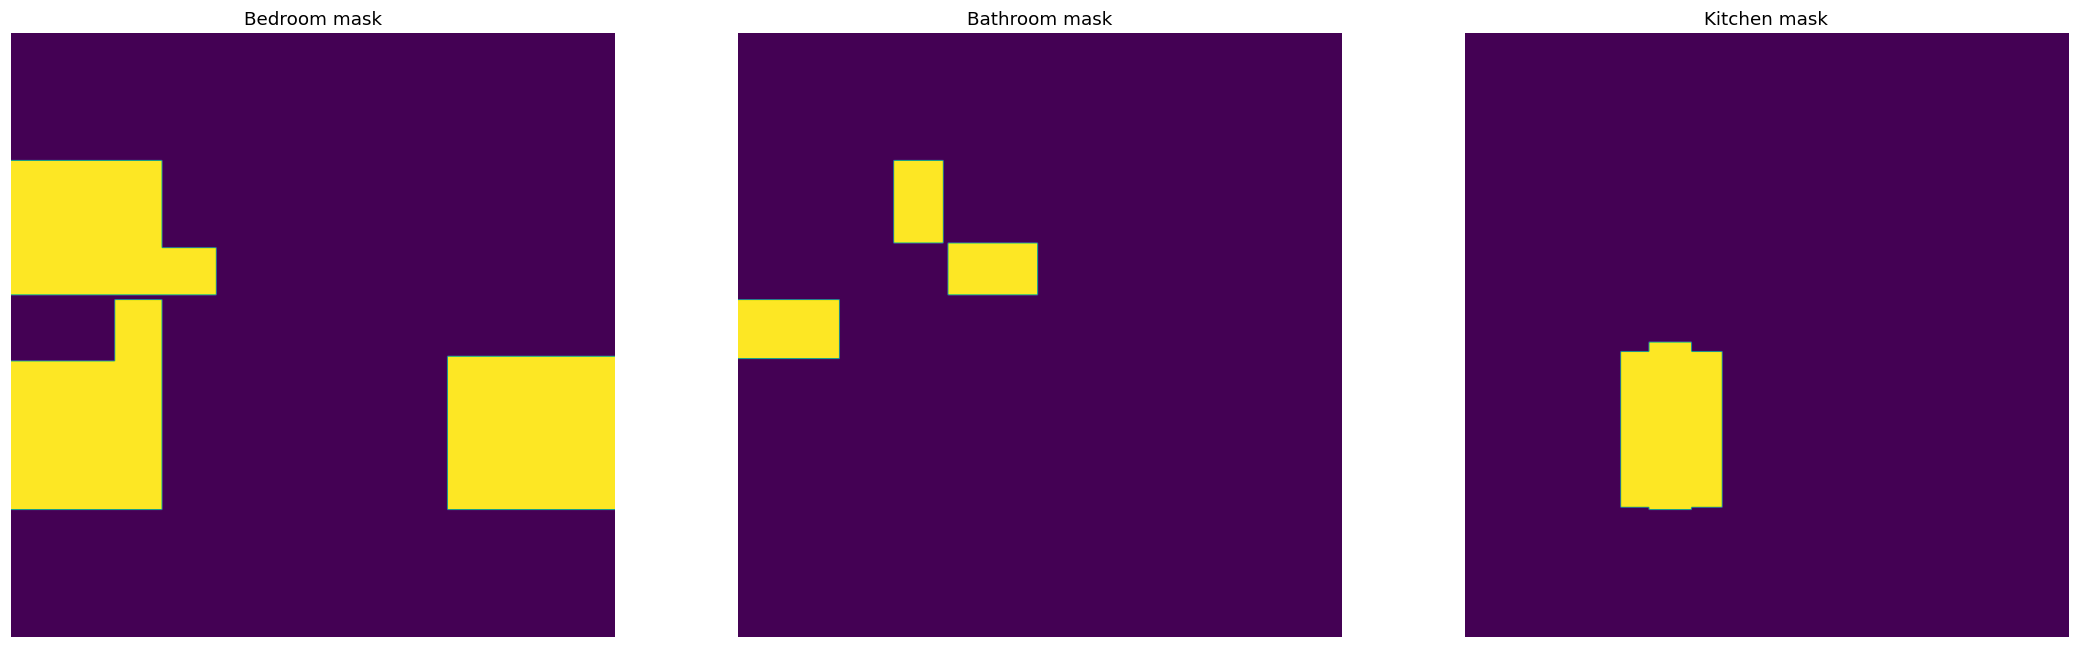

In [13]:
shape = (256, 256)  # target canvas HxW

bed_mask  = geometry_to_mask(plan.get('bedroom'), shape=shape)
bath_mask = geometry_to_mask(plan.get('bathroom'), shape=shape)
kit_mask  = geometry_to_mask(plan.get('kitchen'), shape=shape)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].imshow(bed_mask,); axs[0].set_title('Bedroom mask');  axs[0].axis('off')
axs[1].imshow(bath_mask); axs[1].set_title('Bathroom mask'); axs[1].axis('off')
axs[2].imshow(kit_mask); axs[2].set_title('Kitchen mask');  axs[2].axis('off')
plt.tight_layout(); plt.show()

## 5) Simple augmentations (rotate / vertical flip / scale)

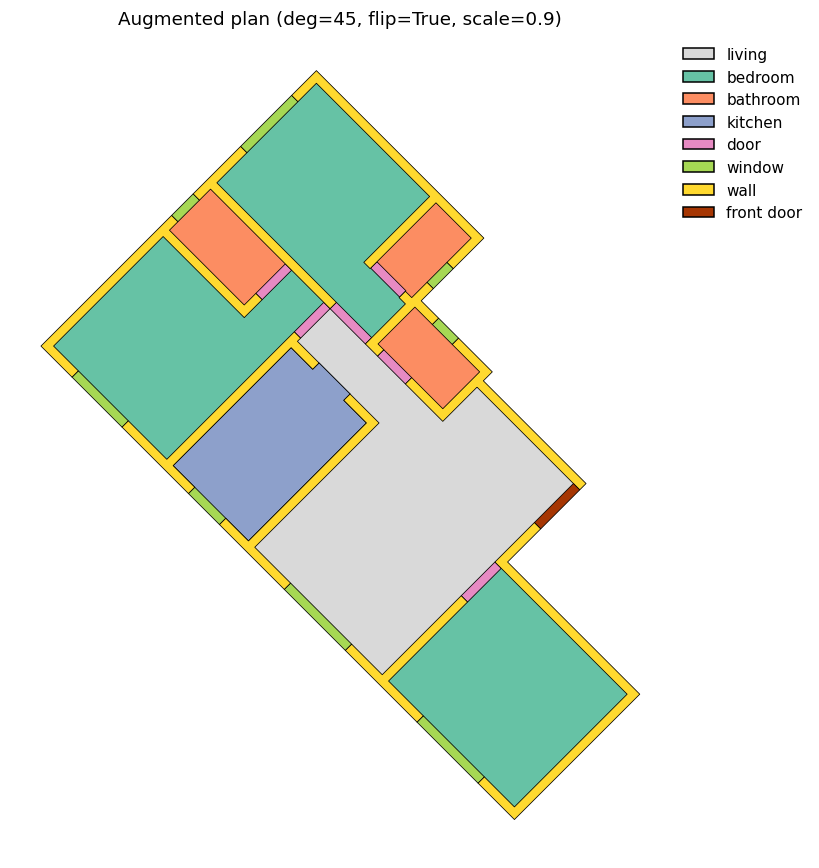

In [14]:
aug_deg  = 45       # rotate 90 degrees
aug_flip = True      # vertical flip **
aug_scale = 0.9      # scale down a bit
canvas_size = 256

aug_plan = dict(plan)  # shallow copy
for key in ['living','bedroom','bathroom','kitchen','door','window','wall','front_door','balcony']:
    if key in aug_plan and aug_plan[key] is not None:
        aug_plan[key] = augment_geom(aug_plan[key], degree=aug_deg, flip_vertical=aug_flip, scale=aug_scale, size=canvas_size)

ax = plot_plan(aug_plan, title=f'Augmented plan (deg={aug_deg}, flip={aug_flip}, scale={aug_scale})')
plt.show()

## 6) Buffer helpers (shrink→expand / expand→shrink)
These are handy for morphological cleanup or filling tiny gaps.

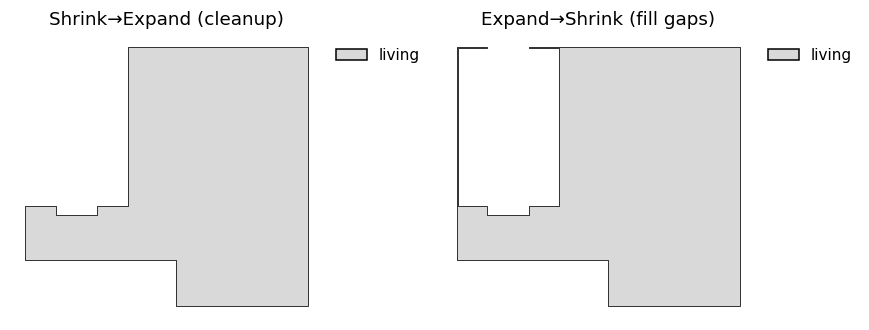

In [15]:
if plan.get('living') is not None:
    ww = float(plan.get('wall_width', 3.0) or 3.0)
    cleaned = buffer_shrink_expand(plan['living'], ww/2)
    filled  = buffer_expand_shrink(plan['living'], ww/2)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    plot_plan({'living': cleaned}, title='Shrink→Expand (cleanup)', ax=axs[0]); axs[0].set_axis_off()
    plot_plan({'living': filled},  title='Expand→Shrink (fill gaps)', ax=axs[1]); axs[1].set_axis_off()
    plt.tight_layout(); plt.show()

## 7) Plan → graph + overlay

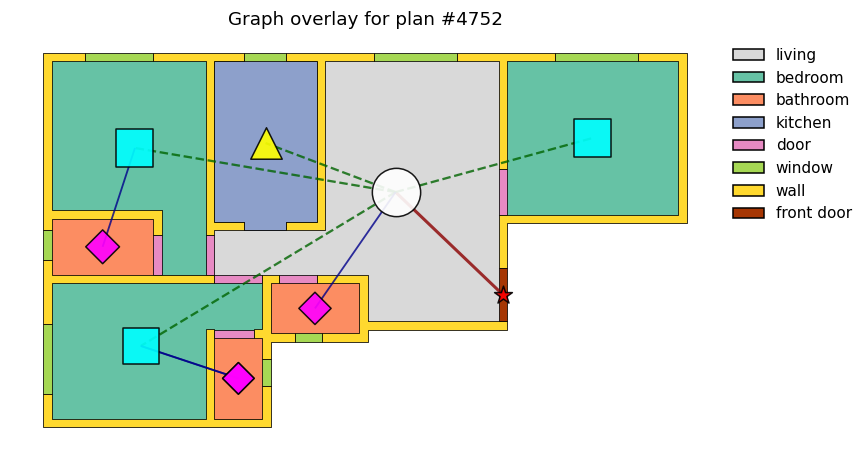

Graph nodes: 10, edges: 6


In [16]:
ax = plot_plan_and_graph(plan, title=f'Graph overlay for plan #{idx}')
plt.show()

G = plan_to_graph(plan)
print(f'Graph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}')

## 8) build a multi-channel mask tensor

In [17]:
def multi_mask(plan, keys=('living','bedroom','bathroom','kitchen'), size=(256,256)):
    chans = []
    for k in keys:
        chans.append(geometry_to_mask(plan.get(k), shape=size) / 255.0)  # normalize to [0,1]
    return np.stack(chans, axis=0)  # CxHxW

mm = multi_mask(plan)
print('Multi-mask shape (C,H,W):', mm.shape)

Multi-mask shape (C,H,W): (4, 256, 256)


## 9) Batch export a few samples

In [18]:
out_dir = 'plan_pngs'
os.makedirs(out_dir, exist_ok=True)

for i in range(5):
    j = random.randrange(len(plans))
    ax = plot_plan_and_graph(plans[j], title=f'Plan {j}')
    out_path = os.path.join(out_dir, f'plan_{j}.png')
    plt.savefig(out_path, bbox_inches='tight', pad_inches=0, dpi=200)
    plt.close()
print('Saved example figures to:', out_dir)

Saved example figures to: plan_pngs
